#### Pytorch classification with nns
and dummy datasets

In [1]:
from sklearn.datasets import make_circles

In [2]:
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03)

In [3]:
X[:5]

array([[ 0.6026297 , -0.72855791],
       [ 0.87512183,  0.46635858],
       [ 0.61457101, -0.51849345],
       [-0.10917731,  0.76959413],
       [-0.99520378,  0.27288961]])

In [4]:
y[:5]

array([0, 0, 1, 1, 0], dtype=int64)

In [5]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head()

,X1,X2,label
0,0.602630,-0.728558,0
1,0.875122,0.466359,0
2,0.614571,-0.518493,1
3,-0.109177,0.769594,1
4,-0.995204,0.272890,0


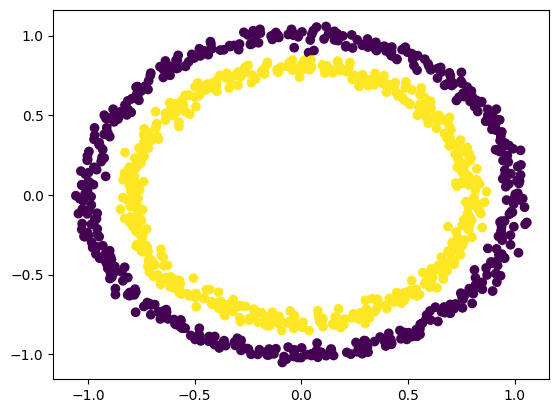

In [6]:
import matplotlib.pyplot as plt
plt.scatter(x=circles["X1"],
            y=circles["X2"],
            c=circles["label"])

In [7]:
import torch
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

#### Turn data into torch tensors

In [8]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [9]:
X[:5]

tensor([[ 0.6026, -0.7286],
        [ 0.8751,  0.4664],
        [ 0.6146, -0.5185],
        [-0.1092,  0.7696],
        [-0.9952,  0.2729]])

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2)
len(X_train), len(y_test)

(800, 200)

### Building a module

In [11]:
from torch import nn

In [12]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=2, out_features = 10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features = 10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1),
            # nn.ReLU(),
            # nn.Sigmoid()
        )
        # self.activation = torch.nn.Sigmoid()
    def forward(self, x):
        # x = self.model(x)
        # out = self.activation(x)
        logits = self.model(x)
        return logits
        # return self.model(x)

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [13]:
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.0182],
        [ 0.0291],
        [-0.0049],
        [ 0.0565],
        [ 0.0167],
        [ 0.0040],
        [ 0.0434],
        [-0.0221],
        [-0.0128],
        [ 0.0499]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 1., 1., 0., 0.])


#### Loss, optim, training

In [14]:
# loss_fn = nn.BCELoss()

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [15]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [16]:
y_pred_probs = model_0(X_test.to(device))[:5]
# get binary class labels
y_preds = torch.round(y_pred_probs)
# get rid of extra dimenstions
y_preds.squeeze()

tensor([-0., 0., -0., 0., 0.], grad_fn=<SqueezeBackward0>)

#### Training loop

In [17]:
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    # y_pred = model_0(X_train).squeeze()
    # y_pred = torch.round(y_pred)
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits

    # loss = loss_fn(y_pred, y_train)
    
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_0(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # test_pred = model_0(X_test).squeeze()
      # test_pred = torch.round(test_pred)
        
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      # test_loss = loss_fn(test_pred, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69398, Accuracy: 52.12% | Test Loss: 0.69490, Test Accuracy: 48.00%
Epoch: 100 | Loss: 0.69184, Accuracy: 50.88% | Test Loss: 0.69218, Test Accuracy: 50.00%
Epoch: 200 | Loss: 0.69072, Accuracy: 51.62% | Test Loss: 0.69071, Test Accuracy: 51.50%
Epoch: 300 | Loss: 0.68940, Accuracy: 54.50% | Test Loss: 0.68917, Test Accuracy: 54.00%
Epoch: 400 | Loss: 0.68760, Accuracy: 58.63% | Test Loss: 0.68752, Test Accuracy: 57.00%
Epoch: 500 | Loss: 0.68519, Accuracy: 60.62% | Test Loss: 0.68570, Test Accuracy: 59.00%
Epoch: 600 | Loss: 0.68170, Accuracy: 59.75% | Test Loss: 0.68337, Test Accuracy: 59.00%
Epoch: 700 | Loss: 0.67615, Accuracy: 60.88% | Test Loss: 0.67930, Test Accuracy: 58.50%
Epoch: 800 | Loss: 0.66768, Accuracy: 61.25% | Test Loss: 0.67294, Test Accuracy: 58.00%
Epoch: 900 | Loss: 0.65424, Accuracy: 62.75% | Test Loss: 0.66372, Test Accuracy: 57.50%


#### Download a script with helper functions

In [18]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


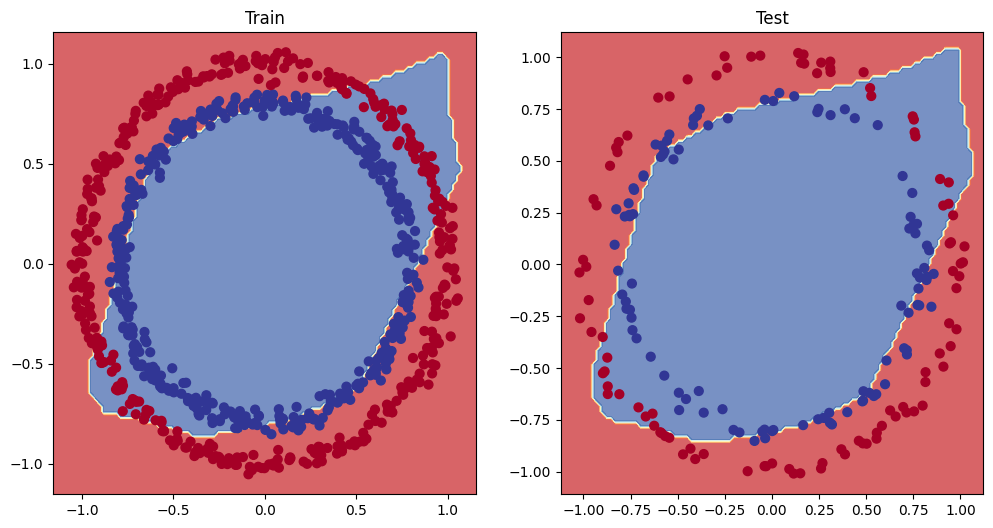

In [19]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### Multiclass classification

In [20]:
from sklearn.datasets import make_blobs

tensor([[ -6.9939,   7.2899],
        [ -4.4025,  -2.5113],
        [ -4.6778,   6.7178],
        [ -6.7448,  -2.3183],
        [-10.2257,   1.8480]]) tensor([2, 1, 2, 1, 0])


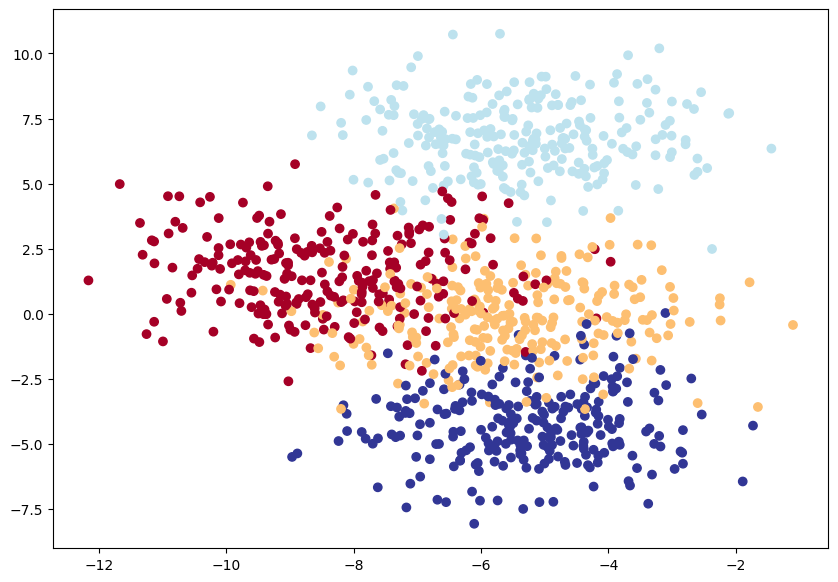

In [25]:
NUM_CLASSES = 4
NUM_FEATURES = 2

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [33]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        logits = self.model(x)
        return logits

In [34]:
model_1 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=20)

In [35]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr=0.1)

In [36]:
# def multiclass_accuracy(y_pred, y_true):
#     y_pred = torch.argmax(y_pred)
#     torch.eq(y_pred, y_true).sum()
    

In [38]:
X_blob_5 = X_blob_train[:5]
y_blob_5 = y_blob_train[:5]

In [40]:
X_blob_5

tensor([[ -3.1040,   0.0298],
        [ -3.3547,  -4.4034],
        [ -8.8916,   2.4832],
        [ -4.4402,  -4.3744],
        [-10.2544,   4.4915]])

In [50]:
y_logits_5 = model_1(X_blob_5)
# y_logits_5.shape
print('logits')
print(y_logits_5)
y_pred_5 = torch.softmax(y_logits_5, dim=1).argmax(dim=1)
print('preds')
print(y_pred_5)
# y_pred_5

logits
tensor([[-0.2815,  0.0549,  0.2497, -0.1665],
        [ 0.0014, -0.0350,  0.1734, -0.0853],
        [-0.5375,  0.4065,  0.5074, -0.1411],
        [-0.0603, -0.0020,  0.1845, -0.1478],
        [-0.6705,  0.5615,  0.6542, -0.0898]], grad_fn=<AddmmBackward0>)
preds
tensor([2, 2, 2, 2, 2])


In [53]:
n_epochs = 1000

for epoch in range(n_epochs):
    y_logits = model_1(X_blob_train)
    y_pred = torch.round(torch.softmax(y_logits, dim=1).argmax(dim=1))

    loss = loss_fn(y_logits,
                   y_blob_train)

    acc = accuracy_fn(y_pred,
                      y_blob_train)
    
    optimizer.zero_grad()
    
    loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_blob_test)
        test_pred = torch.round(torch.softmax(test_logits, dim=1).argmax(dim=1))

        loss = loss_fn(test_logits,
                       y_blob_test)

        test_acc = accuracy_fn(test_pred,
                               y_blob_test)

        if epoch % 100 == 0:
            print(f'Loss: {loss}, acc: {acc}, test acc: {test_acc}')
        

Loss: 1.277843952178955, acc: 18.875, test acc: 27.500000000000004
Loss: 0.403697669506073, acc: 84.125, test acc: 80.0
Loss: 0.37528538703918457, acc: 86.875, test acc: 82.0
Loss: 0.35657963156700134, acc: 87.125, test acc: 83.5
Loss: 0.34354764223098755, acc: 87.5, test acc: 84.5
Loss: 0.3340875506401062, acc: 87.75, test acc: 83.5
Loss: 0.32681992650032043, acc: 87.875, test acc: 84.0
Loss: 0.32163357734680176, acc: 88.25, test acc: 85.0
Loss: 0.31834471225738525, acc: 88.5, test acc: 86.0
Loss: 0.31631308794021606, acc: 88.25, test acc: 86.0


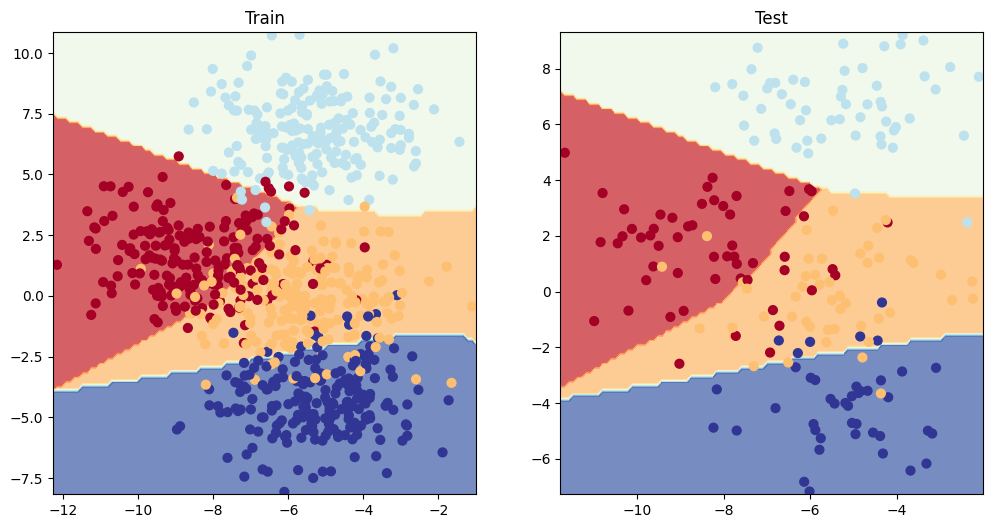

In [54]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_blob_test, y_blob_test)